# Градиентное обучение спайковых нейронных сетей
Задача - обучить спайковую нейросеть распознавать жесты из датасета DVS128 Gesture. 

## Задание
* Скачайте датасет IBM DVS Gesture (см. Tutorial 7 по snnTorch)
* Из данных оставьте три класса: arm roll, hand clap, air drums
* Реализуйте сверточную спайковую нейросеть (см. Tutorial 6)  
* Выберите функцию ошибки и обучите нейросеть
* Оцените качество классификации

## References

[1] https://snntorch.readthedocs.io/en/latest/tutorials/index.html

# Библиотеки

In [12]:
import pandas as pd
import seaborn as sns

In [1]:
!pip install snntorch tonic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 1.9 MB/s 
     |████████████████████████████████| 99 kB 4.8 MB/s 
     |████████████████████████████████| 112 kB 64.3 MB/s 
  Created wheel for importRosbag: filename=importRosbag-1.0.3-py3-none-any.whl size=25470 sha256=8fd380b2106887d8b32d4fd2c574c0c901f4c0866c746df01ec0503ad293e7fe
  Stored in directory: /root/.cache/pip/wheels/d4/19/59/e18178eb4d913524eda743437fe6958fbc837365ee328a4dbe
Successfully built importRosbag


In [2]:
import tonic
import tonic.transforms as transforms
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
import torch
import torchvision
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import numpy as np
import random

np.random.seed(87)
random.seed(87)
torch.manual_seed(87)
torch.cuda.manual_seed(87)

In [28]:
import time

# Подготовка и изучение данных

In [13]:
%%time
dataset = tonic.datasets.DVSGesture(save_to='./data', train=True)
events, target = dataset[0]

  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTrain.tar.gz to ./data/DVSGesture
CPU times: user 1min 11s, sys: 17.8 s, total: 1min 29s
Wall time: 2min 38s


In [14]:
sensor_size = tonic.datasets.DVSGesture.sensor_size
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=5)

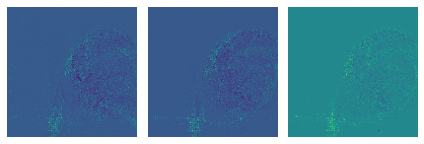

In [15]:
tonic.utils.plot_event_grid(events)

In [17]:
import csv
with open('gesture_mapping.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        print(', '.join(row))

action,label
hand_clapping,1
right_hand_wave,2
left_hand_wave,3
right_hand_clockwise, ,4
right_hand_counter_clockwise, ,5
left_hand_clockwise, ,6
left_hand_counter_clockwise, ,7
forearm_roll_forward,8
forearm_roll_backward,8
drums,9
guitar,10
random_other_gestures,11


In [18]:
dict_data = dict(zip(dataset.data, dataset.targets))

In [21]:
key_to_delete = []
for key in dict_data.keys():
    if (dict_data[key] != 8 and  dict_data[key] != 1 and dict_data[key] != 9):
        #print(dict_data[key])
        key_to_delete.append(key)
    else: # renaming targets
        if dict_data[key] == 8:
            dict_data[key] = 0
        if dict_data[key] == 9:
            dict_data[key] = 2

In [20]:
for i in key_to_delete:
    dict_data.pop(i)

In [22]:
data = list(dict_data.keys())
targets = list(dict_data.values())

In [23]:
dff = pd.DataFrame(targets, columns=['targets'])

res = dff['targets'].value_counts().to_frame().reset_index().sort_values('index')

# renaming the columns
res.columns = ['targets', 'Count']

display(res)

,targets,Count
1,0,98
0,1,98
2,2,98


# Подготовка данных train test

In [98]:
train_data = tonic.datasets.DVSGesture(save_to='./data/train', train=True)
test_data = tonic.datasets.DVSGesture(save_to='./data/test', train=False)

In [99]:
train_pop_list = []
test_pop_list = []
for i in range(len(train_data)):
    if train_data.targets[i] not in [7, 0, 8]:
        train_pop_list.append(i)
    elif train_data.targets[i] in [7, 8]:
        train_data.targets[i] -= 6


for i in range(len(test_data)):
    if test_data.targets[i] not in [7, 0, 8]:
        test_pop_list.append(i)
    elif test_data.targets[i] in [7, 8]:
        test_data.targets[i] -= 6

for i in sorted(train_pop_list, reverse=True):
    del train_data.data[i]
    del train_data.targets[i]

for i in sorted(test_pop_list, reverse=True):
    del test_data.data[i]
    del test_data.targets[i]

In [100]:
train_data.targets[:5]

[2, 1, 0, 2, 1]

In [101]:
test_data.targets[:5]

[2, 1, 0, 2, 1]

In [102]:
dff = pd.DataFrame(train_data.targets, columns=['targets'])

res = dff['targets'].value_counts().to_frame().reset_index().sort_values('index')

# renaming the columns
res.columns = ['targets', 'Count']

display(res)

,targets,Count
2,0,97
1,1,98
0,2,98


In [75]:
#del(dff)

In [103]:
dfff = pd.DataFrame(test_data.targets, columns=['targets'])

res = dfff['targets'].value_counts().to_frame().reset_index().sort_values('index')

# renaming the columns
res.columns = ['targets', 'Count']

display(res)

,targets,Count
2,0,24
1,1,24
0,2,24


In [104]:
sensor_size = tonic.datasets.DVSGesture.sensor_size
target_size = (32, 32, 2)
frame_transform = transforms.Compose([transforms.CenterCrop(sensor_size, target_size),
                                      transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=target_size,
                                                         time_window=10000)])

train_data.transform = frame_transform
test_data.transform = frame_transform

In [6]:
#!rm -r cache

rm: cannot remove 'cache': No such file or directory


In [105]:
transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10, 10])])

cached_train = DiskCachedDataset(train_data, transform=transform, cache_path='./cache/train')

cached_test = DiskCachedDataset(test_data, cache_path='./cache/test')

batch_size = 32
trainloader = DataLoader(cached_train, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))
testloader = DataLoader(cached_test, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Инициализация модели

In [106]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

spike_grad = surrogate.atan()
beta = 0.5

model = nn.Sequential(nn.Conv2d(2, 32, 3),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(32, 64, 3),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*5*5, 3),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [107]:
def forward_pass(model, data):
  spk_rec = []
  utils.reset(model)

  for step in range(data.size(0)):
      spk_out, mem_out = model(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

# Обучение модели

## Общее

In [108]:
num_epochs = 13

In [114]:
def train_check_model(optimizer, loss_fn):
  print('optimizer = ',optimizer,'\n')
  print('loss_fn = ',loss_fn)
  start_time = time.time()
  acc = [0]
  acc_diff = 0
  for epoch in range(num_epochs):
      start = time.time()
      train_iters = 0
      train_acc = 0
      train_loss = 0
      for data, targets in trainloader:
          data = data.to(device)
          targets = targets.to(device)

          model.train()
          spk_rec = forward_pass(model, data)
          loss_val = loss_fn(spk_rec, targets)

          optimizer.zero_grad()
          loss_val.backward()
          optimizer.step()

          train_loss += loss_val.item()
          train_acc += SF.accuracy_rate(spk_rec, targets)
          train_iters += 1

      eval_iters = 0
      eval_acc = 0
      with torch.no_grad():
          model.eval()
          for data, targets in testloader:
              data = data.to(device)
              targets = targets.to(device)
              spk_rec = forward_pass(model, data)
              eval_acc += SF.accuracy_rate(spk_rec, targets)
              eval_iters += 1
      acc.append(train_acc/train_iters)
      if epoch > 0:
        if acc[epoch]-acc[epoch-1] == 0:
          acc_diff += 1
      print(f"\nEpoch {epoch+1}")
      print(f"Amount of epoch without improving accurancy {acc_diff}")
      print(f"Train Loss: {train_loss/train_iters:.2f} Train Accuracy: {train_acc/train_iters:.2f}")
      print(f"Eval Accuracy: {eval_acc/eval_iters:.2f}")
      print('end time = ' ,round(time.time() - start),'\n')
      if acc_diff == 5:
        print(f"already {acc_diff} epochs without improving accurancy")
        print('end time = ' ,round(time.time() - start_time),'for 5 epochs \n')
        break

## Adam

In [115]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [11]:
for epoch in range(num_epochs):
    train_iters = 0
    train_acc = 0
    train_loss = 0
    for data, targets in trainloader:
        data = data.to(device)
        targets = targets.to(device)

        model.train()
        spk_rec = forward_pass(model, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        train_loss += loss_val.item()
        train_acc += SF.accuracy_rate(spk_rec, targets)
        train_iters += 1

    eval_iters = 0
    eval_acc = 0
    with torch.no_grad():
        model.eval()
        for data, targets in testloader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = forward_pass(model, data)
            eval_acc += SF.accuracy_rate(spk_rec, targets)
            eval_iters += 1
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss/train_iters:.2f} Train Accuracy: {train_acc/train_iters:.2f}")
    print(f"Eval Accuracy: {eval_acc/eval_iters:.2f}\n")

Epoch 1
Train Loss: 175.29 Train Accuracy: 0.32
Eval Accuracy: 0.33

Epoch 2
Train Loss: 150.89 Train Accuracy: 0.31
Eval Accuracy: 0.40

Epoch 3
Train Loss: 137.11 Train Accuracy: 0.33
Eval Accuracy: 0.31

Epoch 4
Train Loss: 118.05 Train Accuracy: 0.41
Eval Accuracy: 0.48

Epoch 5
Train Loss: 115.59 Train Accuracy: 0.40
Eval Accuracy: 0.33

Epoch 6
Train Loss: 97.72 Train Accuracy: 0.42
Eval Accuracy: 0.40

Epoch 7
Train Loss: 77.25 Train Accuracy: 0.54
Eval Accuracy: 0.41

Epoch 8
Train Loss: 74.76 Train Accuracy: 0.55
Eval Accuracy: 0.47

Epoch 9
Train Loss: 70.07 Train Accuracy: 0.60
Eval Accuracy: 0.58

Epoch 10
Train Loss: 140.61 Train Accuracy: 0.52
Eval Accuracy: 0.41

Epoch 11
Train Loss: 95.05 Train Accuracy: 0.55
Eval Accuracy: 0.43

Epoch 12
Train Loss: 77.04 Train Accuracy: 0.62
Eval Accuracy: 0.49

Epoch 13
Train Loss: 71.63 Train Accuracy: 0.62
Eval Accuracy: 0.44

Epoch 14
Train Loss: 61.26 Train Accuracy: 0.66
Eval Accuracy: 0.58

Epoch 15
Train Loss: 62.63 Train Accu

Epoch 29


Train Loss: 37.47

Train Accuracy: 0.82


Eval Accuracy: 0.70


In [53]:
loss_fn = SF.ce_max_membrane_loss()
train_check_model(optimizer, loss_fn)



Epoch 1
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  44 


Epoch 2
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  42 


Epoch 3
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  41 


Epoch 4
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  43 


Epoch 5
Train Loss: 1.22 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  49 



In [56]:
loss_fn = SF.ce_rate_loss()
train_check_model(optimizer, loss_fn)


Epoch 1
Amount of epoch without improving accurancy 1
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  42 


Epoch 2
Amount of epoch without improving accurancy 1
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  41 


Epoch 3
Amount of epoch without improving accurancy 2
Train Loss: 1.12 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  40 


Epoch 4
Amount of epoch without improving accurancy 2
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  40 


Epoch 5
Amount of epoch without improving accurancy 3
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  39 


Epoch 6
Amount of epoch without improving accurancy 4
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  42 


Epoch 7
Amount of epoch without improving accurancy 5
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  44 

too many epochs 5 without improving accurancy


## SGD

In [93]:
optimizer =  torch.optim.SGD(model.parameters(), lr=2e-2, momentum=0.9)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [94]:
train_check_model(optimizer, loss_fn)

optimizer =  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.02
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
) 

loss_fn =  <snntorch.functional.loss.mse_count_loss object at 0x7f5c457b9e20>


RuntimeError: ignored

In [25]:
for epoch in range(num_epochs):
    train_iters = 0
    train_acc = 0
    train_loss = 0
    for data, targets in trainloader:
        data = data.to(device)
        targets = targets.to(device)

        model.train()
        spk_rec = forward_pass(model, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        train_loss += loss_val.item()
        train_acc += SF.accuracy_rate(spk_rec, targets)
        train_iters += 1

    eval_iters = 0
    eval_acc = 0
    with torch.no_grad():
        model.eval()
        for data, targets in testloader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = forward_pass(model, data)
            eval_acc += SF.accuracy_rate(spk_rec, targets)
            eval_iters += 1
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss/train_iters:.2f} Train Accuracy: {train_acc/train_iters:.2f}")
    print(f"Eval Accuracy: {eval_acc/eval_iters:.2f}\n")

Epoch 1
Train Loss: 271.73 Train Accuracy: 0.38
Eval Accuracy: 0.34

Epoch 2
Train Loss: 311.00 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 3
Train Loss: 360.35 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 4
Train Loss: 399.08 Train Accuracy: 0.33
Eval Accuracy: 0.34

Epoch 5
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 6
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 7
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 8
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 9
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 10
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 11
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 12
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 13
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 14
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

Epoch 15
Train Loss: 363.67 T

Epoch 29


Train Loss: 363.67

Train Accuracy: 0.34


Eval Accuracy: 0.34


In [59]:
loss_fn = SF.ce_max_membrane_loss()
train_check_model(optimizer, loss_fn)

loss_fn = SF.ce_rate_loss()
train_check_model(optimizer, loss_fn)


Epoch 1
Amount of epoch without improving accurancy 1
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  39 


Epoch 2
Amount of epoch without improving accurancy 1
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  41 


Epoch 3
Amount of epoch without improving accurancy 2
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  41 


Epoch 4
Amount of epoch without improving accurancy 3
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  47 


Epoch 5
Amount of epoch without improving accurancy 4
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  48 


Epoch 6
Amount of epoch without improving accurancy 5
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  42 

too many epochs 5 without improving accurancy
end time =  258 


Epoch 1
Amount of epoch without improving accurancy 1
Train Loss: 1.10 Train Accuracy: 0.34
Eval Accuracy: 0.34
end time =  42 


Epoch 2
Amount of epoch w

## ADADELTA

In [60]:
optimizer =  torch.optim.Adadelta(model.parameters(), lr=2e-2, weight_decay=0)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [ ]:
train_check_model(optimizer, loss_fn)

уже на 12 эпохах ничего не менялась, и я остановила обучение

Epoch 11


Train Loss: 363.67 

Train Accuracy: 0.34


Eval Accuracy: 0.34

In [61]:
loss_fn = SF.ce_max_membrane_loss()
train_check_model(optimizer, loss_fn)

loss_fn = SF.ce_rate_loss()
train_check_model(optimizer, loss_fn)

KeyboardInterrupt: ignored

## Adagrad

In [ ]:
optimizer =  torch.optim.Adagrad(model.parameters(), lr=2e-2, lr_decay=0, weight_decay=0,
                                 initial_accumulator_value=0, eps=1e-10, foreach=None, maximize=False)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [39]:
%%time
for epoch in range(num_epochs):
    start = time.time()
    train_iters = 0
    train_acc = 0
    train_loss = 0
    for data, targets in trainloader:
        data = data.to(device)
        targets = targets.to(device)

        model.train()
        spk_rec = forward_pass(model, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        train_loss += loss_val.item()
        train_acc += SF.accuracy_rate(spk_rec, targets)
        train_iters += 1

    eval_iters = 0
    eval_acc = 0
    with torch.no_grad():
        model.eval()
        for data, targets in testloader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = forward_pass(model, data)
            eval_acc += SF.accuracy_rate(spk_rec, targets)
            eval_iters += 1
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/train_iters:.2f} Train Accuracy: {train_acc/train_iters:.2f}")
    print(f"Eval Accuracy: {eval_acc/eval_iters:.2f}\n")
    print('end time = ' ,time.time() - start)

Epoch 1
Train Loss: 363.67 Train Accuracy: 0.34
Eval Accuracy: 0.34

end time =  111.73548412322998
Epoch 2
Train Loss: 352.21 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  38.80793762207031
Epoch 3
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  40.39222311973572
Epoch 4
Train Loss: 295.46 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  38.44449257850647
Epoch 5
Train Loss: 347.29 Train Accuracy: 0.30
Eval Accuracy: 0.31

end time =  39.460371017456055
Epoch 6
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  38.76720333099365
Epoch 7
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  38.68186283111572
Epoch 8
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  38.50929117202759
Epoch 9
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  39.724207162857056
Epoch 10
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  38.063589334487915
Epoch

KeyboardInterrupt: ignored

Epoch 20


Train Loss: 300.08 

Train Accuracy: 0.32


Eval Accuracy: 0.31


In [ ]:
loss_fn = SF.ce_max_membrane_loss()
train_check_model(optimizer, loss_fn)

In [ ]:
loss_fn = SF.ce_rate_loss()
train_check_model(optimizer, loss_fn)

## Adamax

In [42]:
optimizer = torch.optim.Adamax(model.parameters(), lr=2e-2,
                               betas=(0.9, 0.999),
                              eps=1e-08, weight_decay=0,
                               foreach=None, maximize=False)
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [43]:
%%time
for epoch in range(num_epochs):
    start = time.time()
    train_iters = 0
    train_acc = 0
    train_loss = 0
    for data, targets in trainloader:
        data = data.to(device)
        targets = targets.to(device)

        model.train()
        spk_rec = forward_pass(model, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        train_loss += loss_val.item()
        train_acc += SF.accuracy_rate(spk_rec, targets)
        train_iters += 1

    eval_iters = 0
    eval_acc = 0
    with torch.no_grad():
        model.eval()
        for data, targets in testloader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = forward_pass(model, data)
            eval_acc += SF.accuracy_rate(spk_rec, targets)
            eval_iters += 1
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss/train_iters:.2f} Train Accuracy: {train_acc/train_iters:.2f}")
    print(f"Eval Accuracy: {eval_acc/eval_iters:.2f}\n")
    print('end time = ' ,time.time() - start)

Epoch 1
Train Loss: 357.87 Train Accuracy: 0.34
Eval Accuracy: 0.34

end time =  42.44909858703613
Epoch 2
Train Loss: 313.55 Train Accuracy: 0.31
Eval Accuracy: 0.31

end time =  39.31799793243408
Epoch 3
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  40.80928587913513
Epoch 4
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  41.7217071056366
Epoch 5
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  39.00747036933899
Epoch 6
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  40.35997819900513
Epoch 7
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  39.02251434326172
Epoch 8
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  42.504390001297
Epoch 9
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  40.09378981590271
Epoch 10
Train Loss: 300.08 Train Accuracy: 0.32
Eval Accuracy: 0.31

end time =  39.79959297180176
Epoch 11
Tra

KeyboardInterrupt: ignored

Epoch 13


Train Loss: 300.08 

Train Accuracy: 0.32


Eval Accuracy: 0.31

In [46]:
loss_fn = SF.ce_max_membrane_loss()
train_check_model(optimizer, loss_fn)


Epoch 1
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  40.125441551208496 


Epoch 2
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  40.42552995681763 


Epoch 3
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  40.33628559112549 


Epoch 4
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  38.7254364490509 


Epoch 5
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  41.361464977264404 


Epoch 6
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  41.128145694732666 


Epoch 7
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  41.65501642227173 


Epoch 8
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  40.599393129348755 


Epoch 9
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  40.17688751220703 



KeyboardInterrupt: ignored

Epoch 9


Train Loss: 1.23 Train Accuracy: 0.32


Eval Accuracy: 0.31


end time =  40.17688751220703 

In [49]:
loss_fn = SF.ce_rate_loss()
train_check_model(optimizer, loss_fn)


Epoch 1
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  41 


Epoch 2
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  40 


Epoch 3
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  47 


Epoch 4
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  46 


Epoch 5
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  44 


Epoch 6
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  47 


Epoch 7
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  49 


Epoch 8
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  47 


Epoch 9
Train Loss: 1.23 Train Accuracy: 0.32
Eval Accuracy: 0.31
end time =  49 



KeyboardInterrupt: ignored

Epoch 9


Train Loss: 1.23 Train Accuracy: 0.32


Eval Accuracy: 0.31


end time =  49 